In [ ]:
import os, sys
from pathlib import Path

_root = next((p for p in [Path(os.getcwd()), *Path(os.getcwd()).parents]
              if p.name == 'cryptoTrading2'), None)
if _root:
    os.chdir(str(_root))
if os.getcwd() not in sys.path:
    sys.path.insert(0, os.getcwd())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsRegressor

from files.functions import (
    base_dir,
    fullDataPath,
    dataSetup,
    trainingCols,
    _time_series_train_val_split,
    _scaler_factory,
    _knn_param_grid,
    _knn_full_grid_search,
    _knn_future_forecast,
    _save_knn_model,
    _standardized_rmse,
    _save_metrics,
)
from files.CONSTANTS import COIN, RESPONSE_VARIABLE, TRAINING_COLUMNS, TEST_DAYS, LIMIT

# KNN Training

K-Nearest Neighbors regression model for crypto price prediction.
This notebook uses the tabular feature set and performs a full grid search over both
KNN hyperparameters (`n_neighbors`, `weights`, `p`) and scaler methods using time-series
cross-validation. Each step is shown explicitly using the underlying helper functions.

Dataset shape: (730, 25)
Features (23): ['open', 'high', 'low', 'volume', 'value', 'SMA_7', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'EMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_STD', 'Volume_MA_7', 'OBV', 'avg_sentiment']
Target: close
Date range: 2024-02-24 00:00:00 → 2026-02-22 00:00:00


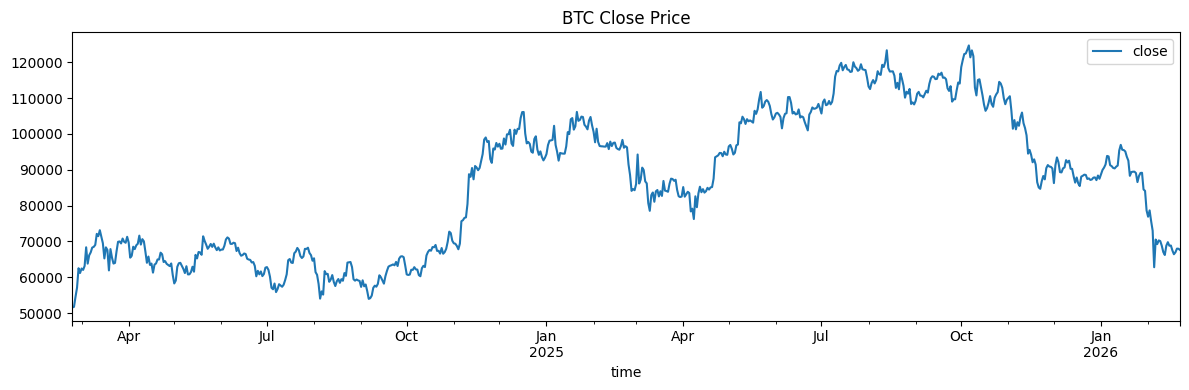


Train size: 584  |  Val size: 146


In [13]:
# ── Step 1: Load Data ────────────────────────────────────────────────────────
raw_path = fullDataPath(COIN)
data = pd.read_csv(raw_path)
daily_data = dataSetup(data, trainingColPath=TRAINING_COLUMNS, response=RESPONSE_VARIABLE, number=LIMIT)
cols = trainingCols(TRAINING_COLUMNS)
X = daily_data[cols].copy()
y = daily_data[RESPONSE_VARIABLE].copy()
print(f"Dataset shape: {daily_data.shape}")
print(f"Features ({len(cols)}): {cols}")
print(f"Target: {RESPONSE_VARIABLE}")
print(f"Date range: {daily_data.index[0]} → {daily_data.index[-1]}")
daily_data[[RESPONSE_VARIABLE]].plot(title=f"{COIN} Close Price", figsize=(12, 4))
plt.tight_layout()
plt.show()

# ── Step 2: Train / Validation Split ─────────────────────────────────────────
X_train, X_val, y_train, y_val = _time_series_train_val_split(X, y)
print(f"\nTrain size: {len(X_train)}  |  Val size: {len(X_val)}")

In [14]:
# ── Step 3: Define Hyperparameter Grid ───────────────────────────────────────
base_param_grid = _knn_param_grid(len(X_train))
scaler_methods = ['standard', 'minmax', 'robust']

print(f"KNN param grid:")
print(f"  n_neighbors options: {base_param_grid['n_neighbors']}")
print(f"  weights options:     {base_param_grid['weights']}")
print(f"  p (Minkowski) options: {base_param_grid['p']}")
print(f"  Scaler methods: {scaler_methods}")

KNN param grid:
  n_neighbors options: [3, 5, 7, 9, 11, 15]
  weights options:     ['uniform', 'distance']
  p (Minkowski) options: [1, 2]
  Scaler methods: ['standard', 'minmax', 'robust']


In [15]:
# ── Step 4: Tune Hyperparameters (full grid search incl. scaler) ──────────────
print("Running KNN full grid search with time-series CV...")
best_combo, tuning_results = _knn_full_grid_search(
    X_train, y_train,
    scaler_methods=scaler_methods,
    base_param_grid=base_param_grid
)

print(f"\nBest combination found:")
for k, v in best_combo.items():
    print(f"  {k}: {v}")

# Display top-5 results
tuning_df = pd.DataFrame(tuning_results).sort_values('rmse').reset_index(drop=True)
print("\nTop-5 tuning results:")
print(tuning_df.head(5).to_string(index=False))

Running KNN full grid search with time-series CV...

Best combination found:
  n_neighbors: 5
  p: 1
  weights: distance
  scaler: minmax
  rmse: 9288.120038967965

Top-5 tuning results:
 n_neighbors  p  weights scaler        rmse
           5  1 distance minmax 9288.120039
           5  1  uniform minmax 9290.831657
           3  1 distance minmax 9348.379897
           3  1  uniform minmax 9349.950024
           7  1 distance minmax 9358.637246


In [16]:
# ── Step 5: Train Best Model ──────────────────────────────────────────────────
best_scaler_method = best_combo['scaler']
best_params = {k: v for k, v in best_combo.items() if k not in ('scaler', 'rmse')}

# Fit scaler
scaler = _scaler_factory(best_scaler_method)
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), index=X_train.index, columns=cols
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val), index=X_val.index, columns=cols
)

# Train KNN model
model = KNeighborsRegressor(**best_params)
model.fit(X_train_scaled, y_train)
print(f"KNN model trained with params: {best_params}")
print(f"Scaler: {best_scaler_method}")

KNN model trained with params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Scaler: minmax


In [17]:
# ── Step 6: Save Model to models/{COIN}/ ─────────────────────────────────────
model_path, scaler_path = _save_knn_model(model, scaler, COIN)
print(f"Model saved to:  {model_path}")
print(f"Scaler saved to: {scaler_path}")

Model saved to:  /Users/sucheen/Documents/cryptoTrading2/models/BTCBTC_knn_model.pkl
Scaler saved to: /Users/sucheen/Documents/cryptoTrading2/models/BTCBTC_scaler.pkl


Validation RMSE:            4,507.82
Standardized RMSE (÷ std):  0.3088


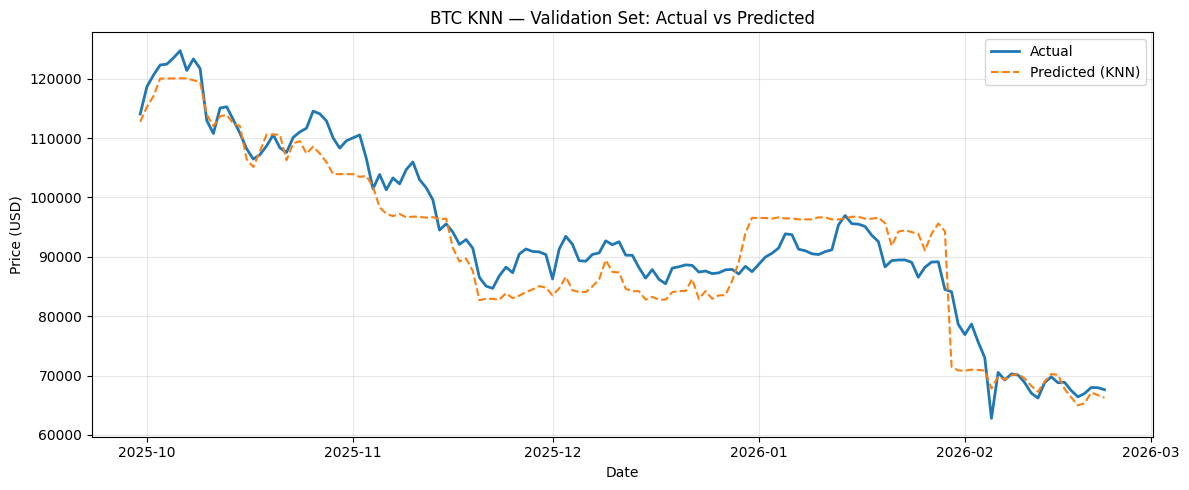

In [18]:
# ── Step 7: Predict on Validation Set ────────────────────────────────────────
val_preds = model.predict(X_val_scaled)
val_df = pd.DataFrame({'predicted_price': val_preds}, index=X_val_scaled.index)

# Compute RMSE
rmse, std_rmse = _standardized_rmse(y_val, val_preds)
print(f"Validation RMSE:            {rmse:,.2f}")
print(f"Standardized RMSE (÷ std):  {std_rmse:.4f}")

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y_val.index, y_val.values, label='Actual', linewidth=2)
ax.plot(val_df.index, val_df['predicted_price'], label='Predicted (KNN)', linestyle='--')
ax.set_title(f"{COIN} KNN — Validation Set: Actual vs Predicted")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Future predictions for next 7 days:
            predicted_price
2026-02-23     66242.576230
2026-02-24     65080.093355
2026-02-25     64331.596631
2026-02-26     64507.756958
2026-02-27     64509.842433
2026-02-28     64509.867124
2026-03-01     64509.867416


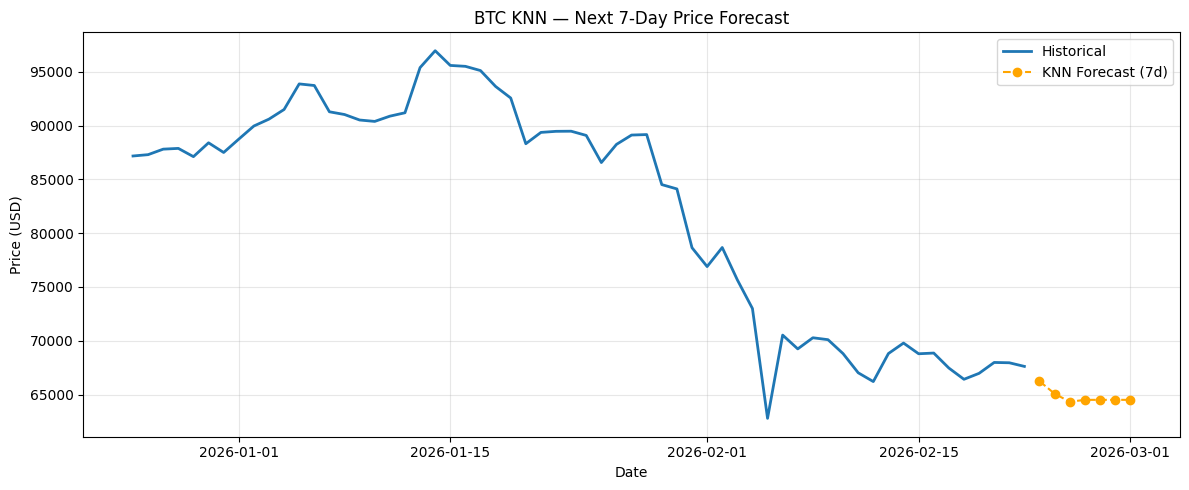

In [19]:
# ── Step 8: Predict Next TEST_DAYS Days ──────────────────────────────────────
future_df = _knn_future_forecast(
    model, scaler, X, daily_data, cols,
    response=RESPONSE_VARIABLE, n=TEST_DAYS
)

print(f"Future predictions for next {TEST_DAYS} days:")
print(future_df.to_string())

# Plot future forecast
fig, ax = plt.subplots(figsize=(12, 5))
hist = daily_data[RESPONSE_VARIABLE].iloc[-60:]
ax.plot(hist.index, hist.values, label='Historical', linewidth=2)
ax.plot(future_df.index, future_df['predicted_price'], marker='o',
        linestyle='--', label=f'KNN Forecast ({TEST_DAYS}d)', color='orange')
ax.set_title(f"{COIN} KNN — Next {TEST_DAYS}-Day Price Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ── Step 9: Save Metrics ──────────────────────────────────────────────────────
metrics_path = _save_metrics(std_rmse, COIN, 'knn')

print(f"Metrics (std RMSE) saved to: {metrics_path}")
print(f"\nStandardized RMSE: {std_rmse:.4f}")
print("Done.")